# Dedupe

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("test_pyspark") \
    .config("spark.driver.memory", "100g") \
    .config("spark.executor.memory", "100g") \
    .config("spark.sql.orc.enableVectorizedReader", "false") \
    .config("spark.sql.parquet.columnarReaderBatchSize", "256") \
    .config("spark.sql.orc.columnarReaderBatchSize", "256") \
    .config("spark.sql.shuffle.partitions", "1024") \
    .config("spark.driver.maxResultSize", "4g") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/07/29 16:34:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/07/29 16:34:51 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/07/29 16:34:51 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [3]:
combined_df = spark.table("dn_labels_combined")

## Create dedup data

In [4]:
combined_distinct_df = combined_df.distinct().orderBy("id", "label", "type")

dedup_data = combined_distinct_df.toPandas()

null_count = dedup_data[dedup_data["id"].isnull()].shape[0]
# format null_nums 5 digit number starting from 00000
null_nums = [f"null{num:05d}" for num in range(0, null_count)]
dedup_data.loc[dedup_data["id"].isnull(), "id"] = null_nums
dedup_data.loc[dedup_data["type"].isnull(), "type"] = "missing"

dedup_data

,label,id,type,source
0,Children,null00000,missing,subject
1,Criminal law,null00001,missing,subject
2,Gender roles,null00002,missing,subject
3,Law,null00003,missing,subject
4,Police,null00004,missing,subject
...,...,...,...,...
646781,Pregnant teenagers - Great Britain - Diaries,zzzvtr3f,Concept,subject
646782,"Maddox, Lucy",zzzw65be,Person,contributor
646783,"Rockliffe, Richard William.",zzzwgbkn,Person,contributor
646784,Aneurysm - drug therapy,zzzygqw9,Concept,subject


### Find rows that label contains "Florence"

In [ ]:


florence_rows = dedup_data[dedup_data['label'].str.contains(
    "Florence", case=False, na=False) & dedup_data['label'].str.contains(
    "Night", case=False, na=False)].sort_values(by='id', ascending=True)
florence_rows

,label,id,type
85167,"Nightingale, Florence, 1820-1910.",d4rsp2n3,Person
85168,"Nightingale, Florence, 1820-1910. Notes on nur...",d4rsp2n3,Agent
85169,"Nightingale, Florence, 1820-1910. Notes on nur...",d4rsp2n3,Person
85170,"Nightingale, Florence, 1820-1910. Notes on nur...",d4rsp2n3,Agent
85536,"Florence Nightingale Museum (London, England)",d56fkgss,Organisation
89221,École Florence Nightingale de Bordeaux,d9d45nkh,Organisation
96274,National Florence Nightingale Memorial Committ...,dhayqztj,Organisation
133254,"Nightingale, Florence (1820-1910)",euzka9gm,Agent
133255,"Nightingale, Florence (1820-1910)",euzka9gm,Organisation
156262,"Florence Nightingale Hospital (London, England)",fqb5m3hw,Organisation


In [ ]:
from wc_simd.dedupe_service import dedup_data_file

# Convert all columns to string type
dedup_data = dedup_data.astype(str)
dedup_data.reset_index(inplace=True)
dedup_data.rename(columns={"index": "idx"}, inplace=True)

dedup_data.to_csv("../" + dedup_data_file, index=True)

## Load dedup data

In [ ]:
import pandas as pd
from wc_simd.dedupe_service import dedup_data_file
dedup_data = pd.read_csv("../" + dedup_data_file, index_col=0)

# force all columns to string type
dedup_data = dedup_data.astype(str)

dedup_data

,idx,label,id,type,source
0,0,Children,null00000,missing,subject
1,1,Criminal law,null00001,missing,subject
2,2,Gender roles,null00002,missing,subject
3,3,Law,null00003,missing,subject
4,4,Police,null00004,missing,subject
...,...,...,...,...,...
646781,646781,Pregnant teenagers - Great Britain - Diaries,zzzvtr3f,Concept,subject
646782,646782,"Maddox, Lucy",zzzw65be,Person,contributor
646783,646783,"Rockliffe, Richard William.",zzzwgbkn,Person,contributor
646784,646784,Aneurysm - drug therapy,zzzygqw9,Concept,subject


## Create blocking map

### Spark Blocking

In [ ]:
dedup_data_df = spark.createDataFrame(dedup_data)

In [ ]:
dedup_data_df.rdd.getNumPartitions()

64

In [ ]:
dedup_data_df.show()

+---+--------------------+---------+-------+-----------+
|idx|               label|       id|   type|     source|
+---+--------------------+---------+-------+-----------+
|  0|            Children|null00000|missing|    subject|
|  1|        Criminal law|null00001|missing|    subject|
|  2|        Gender roles|null00002|missing|    subject|
|  3|                 Law|null00003|missing|    subject|
|  4|              Police|null00004|missing|    subject|
|  5|               Women|null00005|missing|    subject|
|  6|               Womyn|null00006|missing|    subject|
|  7|               Youth|null00007|missing|    subject|
|  8|Circle of State L...| a2233f9d|Meeting|contributor|
|  9|Nelson, Geoffrey ...| a223f5a6| Person|contributor|
| 10|           Wolff, G.| a2249bxm| Person|contributor|
| 11|       Jones, John E| a224b9mp| Person|contributor|
| 12|      Jones, John E.| a224b9mp| Person|contributor|
| 13|Hulverscheidt, Ma...| a224rx5x| Person|contributor|
| 14|Zimmermann, Wilhelm.| a224

In [ ]:
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType
import pandas as pd
from wc_simd.dedupe_service import settings_file
from dedupe import StaticDedupe
from typing import Iterator


def block_pandas(iterator: Iterator[pd.DataFrame]) -> Iterator[pd.DataFrame]:

    for pdf in iterator:
        with open("../" + settings_file, 'rb') as f:
            dedupe = StaticDedupe(f, num_cores=1)

        for field in dedupe.fingerprinter.index_fields:
            field_data = pdf[field].dropna().unique()
            dedupe.fingerprinter.index(field_data, field)

        fingerprint_data = ((row.idx, dict(label=row.label, type=row.type))
                            for idx, row in pdf.iterrows())
        blocked_data = dedupe.fingerprinter(fingerprint_data)

        yield pd.DataFrame(blocked_data, columns=["block_key", "idx"])


blocked_schema = StructType([
    StructField("block_key", StringType(), True),
    StructField("idx", IntegerType(), True),
])

blocked_df = dedup_data_df.mapInPandas(
    block_pandas, schema=blocked_schema)
blocked_df.show()

+---------+---+
|block_key|idx|
+---------+---+
|      1:0|  0|
|      1:1|  0|
|      2:0|  1|
|      3:0|  2|
|      4:0|  3|
|      4:1|  3|
|      5:0|  4|
|      6:0|  5|
|      6:1|  5|
|      6:0|  6|
|      7:1|  6|
|      8:0|  7|
|      8:1|  7|
|      9:0|  8|
|     10:0|  9|
|     10:1|  9|
|     11:0| 10|
|     11:1| 10|
|     12:0| 11|
|     12:1| 11|
+---------+---+
only showing top 20 rows



In [ ]:
blocked_df.write.mode("overwrite").saveAsTable("dn_label_blocks")

In [ ]:
blocked_df = spark.table("dn_label_blocks")

In [ ]:
blocking_map_df = blocked_df.toPandas()
# blocking_map_df.set_index("idx", inplace=True, drop=False)
blocking_map_df

,block_key,idx
0,1:0,141312
1,2:0,141313
2,2:1,141313
3,3:0,141314
4,4:0,141315
...,...,...
938455,8587:1,9212
938456,8587:0,9213
938457,8587:1,9213
938458,8588:0,9214


## Non-Spark blocking

In [ ]:
from wc_simd.dedupe_service import settings_file
from dedupe import StaticDedupe


with open("../" + settings_file, 'rb') as f:
    deduper = StaticDedupe(f, num_cores=8)

for field in deduper.fingerprinter.index_fields:
    print(f"Indexing field: {field}")
    field_data = dedup_data[field].dropna().unique()
    deduper.fingerprinter.index(field_data, field)

fingerprint_data = ((idx, dict(label=row.label, type=row.type)) for idx, row in dedup_data.iterrows())
blocked_data = deduper.fingerprinter(fingerprint_data)

INFO:dedupe.api:Predicate set:
INFO:dedupe.api:SimplePredicate: (firstTwoTokensPredicate, label)
INFO:dedupe.api:SimplePredicate: (oneGramFingerprint, label)


In [ ]:
blocking_map_df = pd.DataFrame(blocked_data, columns=["block_key", "idx"])
blocking_map_df.set_index("block_key", inplace=True)
blocking_map_df.to_csv("../data/dn_blocking_map.csv", index=True)
blocking_map_df

INFO:dedupe.blocking:10000, 0.6576412 seconds
INFO:dedupe.blocking:20000, 1.2528772 seconds
INFO:dedupe.blocking:30000, 1.8461682 seconds
INFO:dedupe.blocking:40000, 2.4414742 seconds
INFO:dedupe.blocking:50000, 3.0324152 seconds
INFO:dedupe.blocking:60000, 3.6229272 seconds
INFO:dedupe.blocking:70000, 4.2134852 seconds
INFO:dedupe.blocking:80000, 4.8062192 seconds
INFO:dedupe.blocking:90000, 5.3969642 seconds
INFO:dedupe.blocking:100000, 5.9892732 seconds
INFO:dedupe.blocking:110000, 6.5806282 seconds
INFO:dedupe.blocking:120000, 7.1722862 seconds
INFO:dedupe.blocking:130000, 7.7620202 seconds
INFO:dedupe.blocking:140000, 8.3527662 seconds
INFO:dedupe.blocking:150000, 8.9478982 seconds
INFO:dedupe.blocking:160000, 9.5412722 seconds
INFO:dedupe.blocking:170000, 10.1313692 seconds
INFO:dedupe.blocking:180000, 10.7233462 seconds
INFO:dedupe.blocking:190000, 11.3171742 seconds
INFO:dedupe.blocking:200000, 11.9110692 seconds
INFO:dedupe.blocking:210000, 12.5069032 seconds
INFO:dedupe.block

,idx
block_key,
Cdehilnr:1,0
Criminal law:0,1
Cailmnrw:1,1
Gender roles:0,2
Gdelnors:1,2
...,...
RWacdefhiklmor:1,646783
Aneurysm drug:0,646784
Aadeghmnprstuy:1,646784


In [ ]:
# Check idx column type
blocking_map_df["idx"] = blocking_map_df["idx"].astype(int)

In [ ]:
blocking_map_df

,idx
block_key,
Cdehilnr:1,0
Criminal law:0,1
Cailmnrw:1,1
Gender roles:0,2
Gdelnors:1,2
...,...
RWacdefhiklmor:1,646783
Aneurysm drug:0,646784
Aadeghmnprstuy:1,646784


In [ ]:
blocking_map_df.groupby("block_key").size().sort_values(ascending=False)

block_key
Great Britain:0             2328
University of:0             1608
United States:0             1094
Symposium on:0               756
International Congress:0     588
                            ... 
CEHUadeghilnoprstvy:1          1
CEHWabdfgilnoprstuy:1          1
CEHWacdefghilnorstuy:1         1
CEHWacdefilmnorstuvz:1         1
賀川 子玄:0                        1
Length: 920565, dtype: int64

## Prep dictionary pairs

In [ ]:
full_data_df = pd.DataFrame(((idx, dict(label=row["label"], type=row["type"]))
                            for idx, row in dedup_data.iterrows()), columns=["idx", "dict"])
full_data_df.set_index("idx", inplace=True)
full_data_df

,dict
idx,
0,"{'label': 'Children', 'type': 'missing'}"
1,"{'label': 'Criminal law', 'type': 'missing'}"
2,"{'label': 'Gender roles', 'type': 'missing'}"
3,"{'label': 'Law', 'type': 'missing'}"
4,"{'label': 'Police', 'type': 'missing'}"
...,...
646781,{'label': 'Pregnant teenagers - Great Britain ...
646782,"{'label': 'Maddox, Lucy', 'type': 'Person'}"
646783,"{'label': 'Rockliffe, Richard William.', 'type..."


## Join dictionary pairs with blocking map

In [ ]:
blocking_result_df = (blocking_map_df
                      .join(blocking_map_df, rsuffix="_r", on="block_key")
             .query('idx < idx_r')
             .join(full_data_df, on="idx")
             .join(full_data_df, on="idx_r", rsuffix="_r")
             )
blocking_result_df

,idx,idx_r,dict,dict_r
block_key,,,,
Cdehilnr:1,0,228859,"{'label': 'Children', 'type': 'missing'}","{'label': 'Children', 'type': 'Concept'}"
Cdehilnr:1,0,264402,"{'label': 'Children', 'type': 'missing'}","{'label': 'Children', 'type': 'Concept'}"
Criminal law:0,1,102628,"{'label': 'Criminal law', 'type': 'missing'}",{'label': 'Criminal law (Roman law) - Early wo...
Criminal law:0,1,180893,"{'label': 'Criminal law', 'type': 'missing'}",{'label': 'Criminal law - United States - Hist...
Criminal law:0,1,306835,"{'label': 'Criminal law', 'type': 'missing'}","{'label': 'Criminal law', 'type': 'Concept'}"
...,...,...,...,...
123678CMWabdefhilnorstvw:1,646760,646762,"{'label': 'Mather, Cotton, 1663-1728. Wonders ...","{'label': 'Mather, Cotton, 1663-1728. Wonders ..."
Mather Cotton:0,646761,646762,"{'label': 'Mather, Cotton, 1663-1728. Wonders ...","{'label': 'Mather, Cotton, 1663-1728. Wonders ..."
123678CMWabdefhilnorstvw:1,646761,646762,"{'label': 'Mather, Cotton, 1663-1728. Wonders ...","{'label': 'Mather, Cotton, 1663-1728. Wonders ..."


In [ ]:
blocking_result_df.to_parquet("../data/dn_labels_blocking_map.parquet", index=True)

In [ ]:
import pandas as pd
blocking_result_df = pd.read_parquet("../data/dn_labels_blocking_map.parquet")

In [ ]:
blocking_result_df

,idx,idx_r,dict,dict_r
block_key,,,,
Childre:0,0,4247,"{'label': 'Children', 'type': 'missing'}","{'label': 'Children of immigrants', 'type': 'C..."
Childre:0,0,4248,"{'label': 'Children', 'type': 'missing'}","{'label': 'Children of immigrants - Denmark', ..."
Childre:0,0,4838,"{'label': 'Children', 'type': 'missing'}",{'label': 'Children - United States - Social c...
Childre:0,0,5353,"{'label': 'Children', 'type': 'missing'}","{'label': 'Child rearing - Case studies', 'typ..."
Childre:0,0,7405,"{'label': 'Children', 'type': 'missing'}",{'label': 'Children's Memorial Hospital (Chica...
...,...,...,...,...
Magdale:0,646757,646758,{'label': 'Magdalen College (University of Oxf...,{'label': 'Magdalen College (University of Oxf...
MatherC:0,646760,646761,"{'label': 'Mather, Cotton, 1663-1728. Wonders ...","{'label': 'Mather, Cotton, 1663-1728. Wonders ..."
MatherC:0,646760,646762,"{'label': 'Mather, Cotton, 1663-1728. Wonders ...","{'label': 'Mather, Cotton, 1663-1728. Wonders ..."


## Train and Load Model

In [ ]:
import pandas as pd
from wc_simd.dedupe_service import dedup_data_file

dedup_data = pd.read_csv("../" + dedup_data_file)

In [ ]:
train_data = {idx: {"label": row.label, "type": row.type}
              for idx, row in dedup_data.iterrows()}

In [ ]:
import dedupe
from wc_simd.dedupe_service import training_file, settings_file, fields

deduper = dedupe.Dedupe(fields, num_cores=8)
with open("../" + training_file) as tf:
    deduper.prepare_training(train_data, training_file=tf)
    deduper.train(recall=0.90)
    with open("../" + settings_file, "wb") as sf:
        deduper.write_settings(sf)
    deduper.cleanup_training()

INFO:dedupe.api:reading training from file
INFO:dedupe.canopy_index:Removing stop word  A
INFO:dedupe.canopy_index:Removing stop word  E
INFO:dedupe.canopy_index:Removing stop word  M
INFO:dedupe.canopy_index:Removing stop word  R
INFO:dedupe.canopy_index:Removing stop word ac
INFO:dedupe.canopy_index:Removing stop word al
INFO:dedupe.canopy_index:Removing stop word ca
INFO:dedupe.canopy_index:Removing stop word ce
INFO:dedupe.canopy_index:Removing stop word d 
INFO:dedupe.canopy_index:Removing stop word di
INFO:dedupe.canopy_index:Removing stop word e 
INFO:dedupe.canopy_index:Removing stop word ed
INFO:dedupe.canopy_index:Removing stop word en
INFO:dedupe.canopy_index:Removing stop word er
INFO:dedupe.canopy_index:Removing stop word he
INFO:dedupe.canopy_index:Removing stop word ic
INFO:dedupe.canopy_index:Removing stop word in
INFO:dedupe.canopy_index:Removing stop word l 
INFO:dedupe.canopy_index:Removing stop word la
INFO:dedupe.canopy_index:Removing stop word ma
INFO:dedupe.canop

In [ ]:
from dedupe import StaticDedupe
from wc_simd.dedupe_service import settings_file

# deduper = StaticDedupe("../" + settings_file, num_cores=8)
with open("../" + settings_file, 'rb') as f:
    deduper = StaticDedupe(f, num_cores=8)

INFO:dedupe.api:Predicate set:
INFO:dedupe.api:TfidfNGramCanopyPredicate: (0.6, label)
INFO:dedupe.api:TfidfNGramCanopyPredicate: (0.8, label)


# Score Clusters

In [ ]:
blocking_result_df.reset_index()["block_key"].unique().shape

(166716,)

In [ ]:
blocking_result_df.groupby("block_key").size().sort_values(ascending=False)

block_key
Great Britain:0             2708628
University of:0             1292028
United States:0              597871
Symposium on:0               285390
International Congress:0     172578
                             ...   
Commedia dellarte:0               1
Commandments Six:0                1
Commandments Judaism:0            1
Command of:0                      1
宇川玄田真:1                           1
Length: 166716, dtype: int64

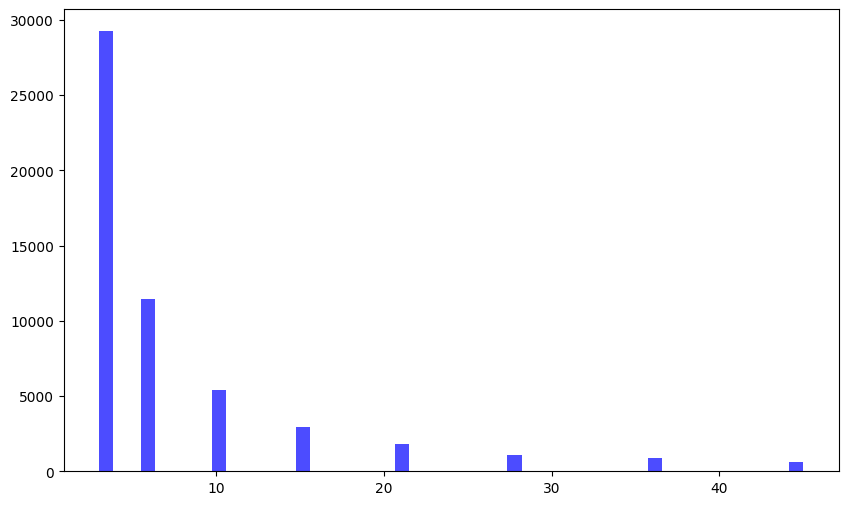

Block sizes statistics:
count    53363.000000
mean         7.129640
std          7.670314
min          3.000000
25%          3.000000
50%          3.000000
75%          6.000000
max         45.000000
dtype: float64


In [ ]:
# Histogram of block sizes
import matplotlib.pyplot as plt
%matplotlib inline

block_sizes = blocking_result_df.groupby("block_key").size()
#filter block sizes greater less than 50
block_sizes = block_sizes[(block_sizes < 50) & (block_sizes > 1)]
plt.figure(figsize=(10, 6))
plt.hist(block_sizes, bins=50, color='blue', alpha=0.7)
# plt.title('Distribution of Block Sizes')
# plt.xlabel('Block Size')
# plt.ylabel('Frequency')
# plt.yscale('log')
# plt.grid(axis='y', alpha=0.75)
plt.show()

print("Block sizes statistics:")
print(block_sizes.describe())

In [ ]:
sample_to_cluster_df = blocking_result_df.head(10000)
sample_to_cluster_df.shape

(10000, 4)

In [ ]:
cluster_data = (((row["idx"], row["dict"]), (row["idx_r"], row["dict_r"]))
                for idx, row in sample_to_cluster_df.iterrows())

clustered_dupes = deduper.cluster(
    deduper.score(cluster_data),
    threshold=0.5)

In [ ]:

def cluster_ids(clustered_dupes):
    for cluster, scores in clustered_dupes:
        cluster_id = cluster[0]
        for entry_id, score in zip(cluster, scores):
            if entry_id == cluster_id:
                continue
            yield entry_id, cluster_id, score

clustered_dupes_df = pd.DataFrame(cluster_ids(clustered_dupes), columns=["id", "canon_id", "prob"]).set_index("id")
clustered_dupes_df

,canon_id,prob
id,,
229720,3,0.521701
131305,7,0.540928
12,11,0.569689
227945,11,0.560265
433219,19,0.633294
...,...,...
346276,547,0.572971
271561,553,0.537086
38815,554,0.633294


In [ ]:
clustered_dupes_df.to_csv("../data/dn_labels_clustered_dupes.csv", index=True)

In [ ]:
import pandas as pd

clustered_dupes_df = pd.read_csv("../data/dn_labels_clustered_dupes.csv", index_col="id")
clustered_dupes_df.sort_values(by="canon_id", ascending=False)

,canon_id,prob
id,,
646513,646511,0.508311
645715,645714,0.312677
645585,645584,0.535532
645336,645335,0.546288
644909,644908,0.416588
...,...,...
78538,0,0.002809
77152,0,0.003086
76679,0,0.001792


In [ ]:
import pandas as pd
from wc_simd.dedupe_service import dedup_data_file

dedup_data = pd.read_csv("../" + dedup_data_file, index_col=0)
dedup_data_indexed = dedup_data[["idx", "label", "type"]].set_index("idx")

In [ ]:
dedup_df = (
    clustered_dupes_df
    .join(dedup_data_indexed)
    .reset_index()
    .set_index("canon_id", drop=False)
    .join(dedup_data_indexed, rsuffix="_canon")
    .query("prob > 0.52")
    # .sort_values(by=["canon_id"], ascending=True)
    
)
dedup_df

,id,canon_id,prob,label,type,label_canon,type_canon
canon_id,,,,,,,
218898,218899,218898,0.549917,"Ashworth, Bryan.",Person,"Ashworth, Bryan.",Person
264320,388020,264320,0.527760,Orientalism in art - History,Concept,Orientalism in art,Concept
92181,92182,92181,0.531241,Punishment - Religious aspects - Christianity,Concept,Punishment - Religious aspects,Concept
338357,338358,338357,0.549917,"Pettigrew, Thomas Joseph, 1791-1865.",Person,"Pettigrew, Thomas Joseph, 1791-1865.",Person
527276,624262,527276,0.531998,"Newman, John",Person,"Newman, John B.",Person
...,...,...,...,...,...,...,...
299985,299986,299985,0.547542,"Henry Frederick, Prince, Duke of Cumberland an...",Person,"Henry Frederick, Prince, Duke of Cumberland an...",Person
80294,450226,80294,0.549917,"Ong, Aihwa.",Person,"Ong, Aihwa.",Person
108624,345863,108624,0.545393,"Corvesi, Pietro, active 16th century",Person,"Corvesi, Pietro, active 16th century.",Person


In [ ]:
dedup_df[~(dedup_df["label"] == dedup_df["label_canon"])]

,id,canon_id,prob,label,type,label_canon,type_canon
canon_id,,,,,,,
264320,388020,264320,0.527760,Orientalism in art - History,Concept,Orientalism in art,Concept
92181,92182,92181,0.531241,Punishment - Religious aspects - Christianity,Concept,Punishment - Religious aspects,Concept
527276,624262,527276,0.531998,"Newman, John",Person,"Newman, John B.",Person
639846,639847,639846,0.538514,"Rivers, Isabel.",Person,"Rivers, Isabel",Person
518760,518761,518760,0.543684,"Scriven, Edward, 1775-1841.",Person,"Scriven, Edward, 1775-1841",Person
...,...,...,...,...,...,...,...
645335,645336,645335,0.546288,"Boisseau, F. G. (François Gabriel), 1791-1836.",Person,"Boisseau, F. G. (François Gabriel), 1791-1836",Person
299985,299986,299985,0.547542,"Henry Frederick, Prince, Duke of Cumberland an...",Person,"Henry Frederick, Prince, Duke of Cumberland an...",Person
108624,345863,108624,0.545393,"Corvesi, Pietro, active 16th century",Person,"Corvesi, Pietro, active 16th century.",Person


In [ ]:
# Install fuzzywuzzy if not available
from fuzzywuzzy import fuzz

# Add similarity score column
dedup_df['similarity_score'] = dedup_df.apply(
    lambda row: fuzz.ratio(str(row['label']), str(row['label_canon'])), axis=1
)

# Filter out rows where labels are very similar (e.g., similarity > 90)
similarity_threshold = 90
filtered_dedup_df = dedup_df[dedup_df['similarity_score'] < similarity_threshold]

print(f"Original rows: {len(dedup_df)}")
print(f"Filtered rows (similarity < {similarity_threshold}): {len(filtered_dedup_df)}")
print(f"Removed {len(dedup_df) - len(filtered_dedup_df)} rows with high similarity")

# Show some examples of what was filtered out
high_similarity_df = dedup_df[dedup_df['similarity_score'] >= similarity_threshold]
print(f"\nExample of filtered out rows (high similarity):")
if len(high_similarity_df) > 0:
    print(high_similarity_df[['label', 'label_canon', 'similarity_score']].head())
else:
    print("No rows with high similarity found")

filtered_dedup_df

Original rows: 3132
Filtered rows (similarity < 90): 1095
Removed 2037 rows with high similarity

Example of filtered out rows (high similarity):
                                                      label  \
canon_id                                                      
218898                                     Ashworth, Bryan.   
338357                 Pettigrew, Thomas Joseph, 1791-1865.   
639846                                      Rivers, Isabel.   
518760                          Scriven, Edward, 1775-1841.   
104248    Lichfield, Sutton Coldfield and Tamworth Hospi...   

                                                label_canon  similarity_score  
canon_id                                                                       
218898                                     Ashworth, Bryan.               100  
338357                 Pettigrew, Thomas Joseph, 1791-1865.               100  
639846                                       Rivers, Isabel                97  
518760      

,id,canon_id,prob,label,type,label_canon,type_canon,similarity_score
canon_id,,,,,,,,
264320,388020,264320,0.527760,Orientalism in art - History,Concept,Orientalism in art,Concept,78
92181,92182,92181,0.531241,Punishment - Religious aspects - Christianity,Concept,Punishment - Religious aspects,Concept,80
527276,624262,527276,0.531998,"Newman, John",Person,"Newman, John B.",Person,89
79172,443059,79172,0.539905,"Adaptation, Physiological",Concept,"Adaptation, Physiological - physiology",Concept,79
625121,625123,625121,0.520070,Pathogenic fungi - Nomenclature,Concept,Pathogenic fungi,Concept,68
...,...,...,...,...,...,...,...,...
22578,624994,22578,0.524425,"Barr, James Smith",Person,"Barr, James",Person,79
506121,506123,506121,0.533860,"Najīb al-Dīn al-Samarqandī, Muḥammad ibn ʻAlī,...",Person,"Najīb al-Dīn al-Samarqandī, Muḥammad ibn ʻAlī,...",Person,82
88869,239257,88869,0.530660,Cape of Good Hope (S.A.),Place,Cape of Good Hope,Place,83


In [ ]:
filtered_dedup_df.to_csv("../data/dn_labels_filtered_dedup_result.csv", index=True)

In [ ]:
filtered_dedup_df.columns

Index(['id', 'canon_id', 'prob', 'label', 'type', 'label_canon', 'type_canon',
       'similarity_score'],
      dtype='object')

In [ ]:
# Analyze similarity score distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Histogram of similarity scores
plt.subplot(1, 2, 1)
plt.hist(dedup_df['similarity_score'], bins=20, alpha=0.7, color='blue')
plt.title('Distribution of Similarity Scores')
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')
plt.axvline(x=similarity_threshold, color='red', linestyle='--', label=f'Threshold: {similarity_threshold}')
plt.legend()

# Box plot
plt.subplot(1, 2, 2)
plt.boxplot(dedup_df['similarity_score'])
plt.title('Similarity Score Box Plot')
plt.ylabel('Similarity Score')

plt.tight_layout()
plt.show()

print("Similarity score statistics:")
print(dedup_df['similarity_score'].describe())

# Show examples at different similarity ranges
print("\n--- Examples by similarity range ---")

# Very different labels (low similarity)
low_sim = dedup_df[dedup_df['similarity_score'] < 30]
if len(low_sim) > 0:
    print(f"\nVery different labels (similarity < 30): {len(low_sim)} rows")
    print(low_sim[['label', 'label_canon', 'similarity_score']].head(3))

# Moderately similar labels
med_sim = dedup_df[(dedup_df['similarity_score'] >= 30) & (dedup_df['similarity_score'] < 70)]
if len(med_sim) > 0:
    print(f"\nModerately similar labels (30-70): {len(med_sim)} rows")
    print(med_sim[['label', 'label_canon', 'similarity_score']].head(3))

# Very similar labels (high similarity)
high_sim = dedup_df[dedup_df['similarity_score'] >= 70]
if len(high_sim) > 0:
    print(f"\nVery similar labels (similarity >= 70): {len(high_sim)} rows")
    print(high_sim[['label', 'label_canon', 'similarity_score']].head(3))

Similarity score statistics:
count    3132.000000
mean       90.931992
std        11.392710
min        33.000000
25%        80.000000
50%        98.000000
75%       100.000000
max       100.000000
Name: similarity_score, dtype: float64

--- Examples by similarity range ---

Moderately similar labels (30-70): 92 rows
                                                   label  \
canon_id                                                   
625121                   Pathogenic fungi - Nomenclature   
139552    Hay, William, 1695-1755. Deformity : an essay.   
75900                    Poultry Diseases - drug therapy   

                       label_canon  similarity_score  
canon_id                                              
625121            Pathogenic fungi                68  
139552    Hay, William, 1695-1755.                69  
75900             Poultry Diseases                68  

Very similar labels (similarity >= 70): 3040 rows
                                                  label

In [ ]:
# Function to filter by different similarity thresholds
def filter_by_similarity(df, threshold=90, show_examples=True):
    filtered_df = df[df['similarity_score'] < threshold]
    removed_count = len(df) - len(filtered_df)
    
    print(f"Threshold: {threshold}")
    print(f"Original rows: {len(df)}")
    print(f"Filtered rows: {len(filtered_df)}")
    print(f"Removed rows: {removed_count} ({removed_count/len(df)*100:.1f}%)")
    
    if show_examples and removed_count > 0:
        removed_df = df[df['similarity_score'] >= threshold]
        print(f"\nExamples of removed rows (similarity >= {threshold}):")
        print(removed_df[['label', 'label_canon', 'similarity_score', 'prob']].head())
    
    return filtered_df

# Try different thresholds
print("=== Experimenting with different similarity thresholds ===\n")

for threshold in [95, 90, 85, 80, 75]:
    print("-" * 50)
    filtered_result = filter_by_similarity(dedup_df, threshold, show_examples=(threshold == 90))
    print()

# You can adjust this threshold based on your needs
final_threshold = 85  # Adjust this value
final_filtered_df = filter_by_similarity(dedup_df, final_threshold, show_examples=True)

print(f"\n=== Final filtered dataframe with threshold {final_threshold} ===")
final_filtered_df.head(10)

=== Experimenting with different similarity thresholds ===

--------------------------------------------------
Threshold: 95
Original rows: 3132
Filtered rows: 1165
Removed rows: 1967 (62.8%)

--------------------------------------------------
Threshold: 90
Original rows: 3132
Filtered rows: 1095
Removed rows: 2037 (65.0%)

Examples of removed rows (similarity >= 90):
                                                      label  \
canon_id                                                      
218898                                     Ashworth, Bryan.   
338357                 Pettigrew, Thomas Joseph, 1791-1865.   
639846                                      Rivers, Isabel.   
518760                          Scriven, Edward, 1775-1841.   
104248    Lichfield, Sutton Coldfield and Tamworth Hospi...   

                                                label_canon  similarity_score  \
canon_id                                                                        
218898                   

,id,canon_id,prob,label,type,label_canon,type_canon,similarity_score
canon_id,,,,,,,,
264320,388020,264320,0.527760,Orientalism in art - History,Concept,Orientalism in art,Concept,78
92181,92182,92181,0.531241,Punishment - Religious aspects - Christianity,Concept,Punishment - Religious aspects,Concept,80
79172,443059,79172,0.539905,"Adaptation, Physiological",Concept,"Adaptation, Physiological - physiology",Concept,79
625121,625123,625121,0.520070,Pathogenic fungi - Nomenclature,Concept,Pathogenic fungi,Concept,68
139552,139553,139552,0.522232,"Hay, William, 1695-1755. Deformity : an essay.",Person,"Hay, William, 1695-1755.",Person,69
178807,441756,178807,0.530213,Leicestershire and Rutland Lunatic Asylum. Com...,Organisation,Leicestershire and Rutland Lunatic Asylum,Organisation,77
235315,514054,235315,0.527506,Technische Universität München. Fakultät für M...,Organisation,Technische Universität München.,Organisation,75
440633,454318,440633,0.523600,Gay erotic photography,Concept,Gay erotic photography - Pictorial works,Concept,71
75900,351703,75900,0.520070,Poultry Diseases - drug therapy,Concept,Poultry Diseases,Concept,68
